DATA COLLECTION

In [6]:
import pandas as pd
import yfinance as yf
import numpy as np


# Get stock price data
ticker = 'ADANIENT.NS'
data = yf.download(ticker, start='2018-01-01', end='2025-06-30')
data.to_csv('ADANIENT_stock.csv')

# Load financials manually (e.g., from Excel)
financials = pd.read_excel("/content/adani_ent.xlsx")

/tmp/ipython-input-3338507363.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2018-01-01', end='2025-06-30')
[*********************100%***********************]  1 of 1 completed


REVENUE FORECASTIONG USING ARIMA

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

revenue = financials['Revenue']
model = ARIMA(revenue, order=(1,1,1))
fit = model.fit()
forecast = fit.forecast(steps=5)  # Forecast 5 years
print(forecast)

8     361233.656284
9     363053.417441
10    363133.963789
11    363137.528935
12    363137.686735
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


DCF VALUATION

In [8]:
import numpy as np

# Assume EBITDA margin, tax, capex, WC, and WACC
ebitda_margin = 0.25
tax_rate = 0.25
capex = 100
wc_change = 50
wacc = 0.10

fcf = []
for rev in forecast:
    ebitda = rev * ebitda_margin
    nopat = ebitda * (1 - tax_rate)
    fcf.append(nopat - capex - wc_change)

# Terminal Value and DCF
terminal_value = fcf[-1] * (1 + 0.03) / (wacc - 0.03)
dcf_value = sum([fcf[i] / (1 + wacc) ** (i + 1) for i in range(len(fcf))])
dcf_total = dcf_value + terminal_value / (1 + wacc) ** len(fcf)
print("DCF Valuation:", dcf_total)


DCF Valuation: 877914.0839551099


MONTE CARLO SIMULATION

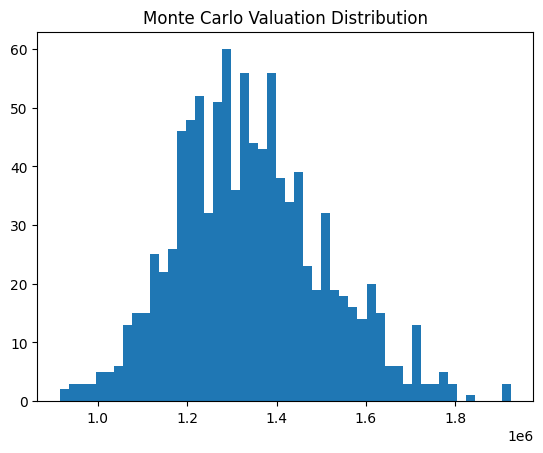

In [10]:
simulations = []
for _ in range(1000):
    rev_growth = np.random.normal(loc=0.10, scale=0.03)
    sim_fcf = []
    rev = forecast.iloc[0]
    for i in range(5):
        rev *= (1 + rev_growth)
        ebitda = rev * ebitda_margin
        nopat = ebitda * (1 - tax_rate)
        sim_fcf.append(nopat - capex - wc_change)
    tv = sim_fcf[-1] * (1 + 0.03) / (wacc - 0.03)
    npv = sum([sim_fcf[i] / (1 + wacc) ** (i + 1) for i in range(5)])
    simulations.append(npv + tv / (1 + wacc) ** 5)

plt.hist(simulations, bins=50)
plt.title("Monte Carlo Valuation Distribution")
plt.show()